In [9]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

In [10]:
fc = FileChooser('/sf/alvra/data/p18594/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18594/raw/scan_info', filename='', show_hidden='False')

In [114]:
quantile_band = 0.5

channel_list = [channel_PIPS_trans, channel_Izero117, channel_Izero122, channel_position_X] #Direction X

#channel_list = [channel_PIPS_trans, channel_Izero117, channel_Izero122, channel_position_Y] #Direction Y


###############################################################3
json_file = fc.selected
#json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal = []
Izero = []
Position_mm = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    print (filename)
    exists = os.path.isfile(filename)
    if exists: # and i !=21:
        clear_output(wait=True)
        print("step", i+1, "of",numFiles, f": Processing {filename}")
        
        results = load_data_compact(channel_list, filename)

        data_trans_shot = results[channel_PIPS_trans]
        
        #Izero_shot = results[channel_Izero122]      
        Izero_shot = results[channel_Izero117]     #Choose which Izero monitor to use (signal on 122 may be too weak)
        
        position_shot = results[channel_position_X]      # Change axis variable here
        
        Signal_shot_norm = data_trans_shot / Izero_shot
        
        df_data = pd.DataFrame(Signal_shot_norm)
        Signal.append(np.nanquantile(df_data, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
        position_shot = [x for x in position_shot if (np.abs(x) > 0)]
        Position_mm.append(np.median(position_shot))
    
Signal = np.asarray(Signal)
Izero = np.asarray(Izero)

Position_mm_readback = load_scan_readback(json_file)
Position_mm = np.asarray(Position_mm)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

step 26 of 26 : Processing /sf/alvra/data/p18594/raw/KnifeEdge_X_14/run_000301.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET           500 / 1001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS117:INTENSITY          477 / 1001 -> 52% loss ▇▇▇▇
SAROP11-PBPS122:INTENSITY          500 / 1001 -> 50% loss ▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS 1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 477 / 1001 -> 52% loss

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.25,0.75


<IPython.core.display.Javascript object>


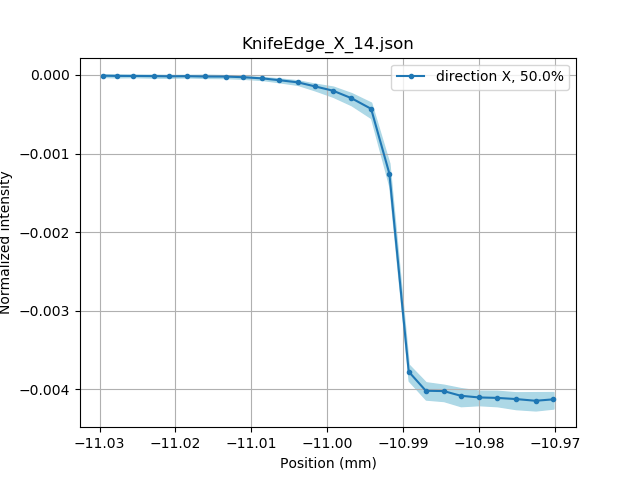

In [115]:
Int = Signal[:,0]
err_low = Signal[:,1]
err_high = Signal[:,2]

plt.figure()
plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')

plt.title(fc.selected_filename)
plt.ylabel('Normalized intensity')
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

In [116]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc_fwhm, Position_mm, Int, p0 = [0, 10, -11.0, 0.1]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = -10.991 mm
Width = 0.003 mm


<IPython.core.display.Javascript object>


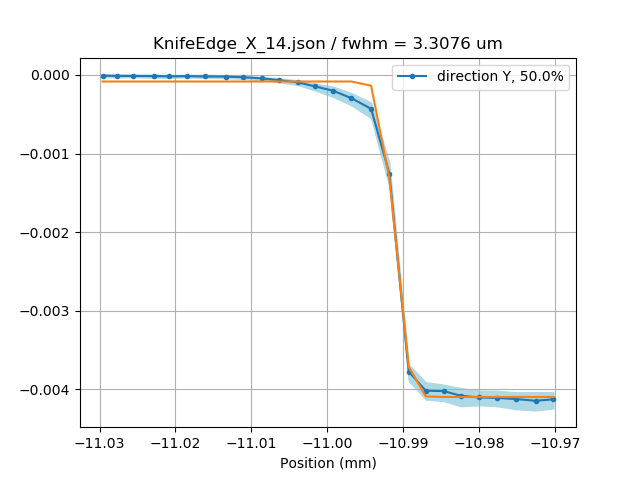

In [117]:
#... and the plot with the fit curve
plt.figure()

plt.plot(Position_mm, Int, label='direction Y, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')
plt.plot(Position_mm, errfunc_fwhm(Position_mm,*parameters))

plt.title(fc.selected_filename + ' / fwhm = {} um'.format(np.round(np.abs(parameters[3])*1000, 4)))
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')

In [ ]:
#Normalization

Signal_norm = Signal #/ Izero
err_Signal_norm = err_Signal #/ Izero

<IPython.core.display.Javascript object>


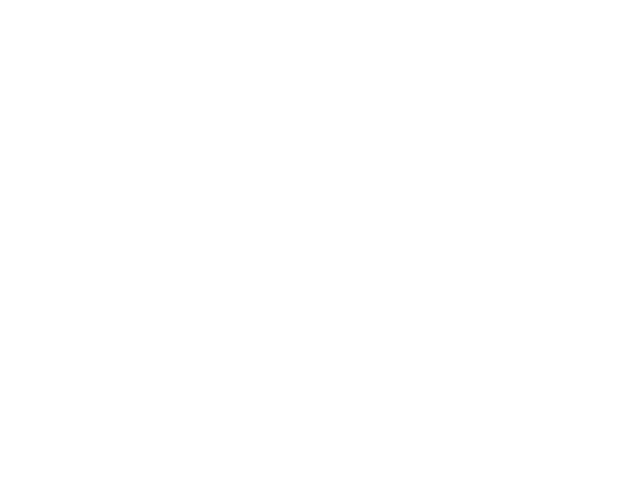

NameError: name 'Signal_norm' is not defined

In [7]:
plt.figure()

plt.plot(Position_mm, Signal_norm, label="FEL",marker='.')
low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm


plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')

In [ ]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc_fwhm, Position_mm, Signal_norm, p0 = [-20, 10, 12.39, 0.1]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

In [ ]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="Direction Y",marker='.')
plt.plot(Position_mm, errfunc_fwhm(Position_mm,*parameters))

low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm

plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(np.abs(parameters[3])*1000, 4) )
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')